In [1]:
filepath = "data/images/001.Black_footed_Albatross/Black_footed_Albatross_0008_1384283201.jpg"
matpath = "data/annotations/001.Black_footed_Albatross/Black_footed_Albatross_0008_1384283201.mat"

In [2]:
import scipy.io

In [3]:
import tensorflow as tf

In [4]:
mat_file = scipy.io.loadmat(matpath)

In [5]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Mar  9 21:48:29 2009',
 '__version__': '1.0',
 '__globals__': [],
 'wikipedia_url': array(['http://en.wikipedia.org/wiki/Black-footed_Albatross'],
       dtype='<U51'),
 'seg': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'bbox': array([[(array([[70]], dtype=uint8), array([[63]], dtype=uint8), array([[499]], dtype=uint16), array([[398]], dtype=uint16))]],
       dtype=[('left', 'O'), ('top', 'O'), ('right', 'O'), ('bottom', 'O')]),
 'flickr_url': array(['http://www.flickr.com/photos/billwalker/1384283201/'],
       dtype='<U51')}

In [6]:
bbox = mat_file['bbox']

In [7]:
bbox

array([[(array([[70]], dtype=uint8), array([[63]], dtype=uint8), array([[499]], dtype=uint16), array([[398]], dtype=uint16))]],
      dtype=[('left', 'O'), ('top', 'O'), ('right', 'O'), ('bottom', 'O')])

In [8]:
left = bbox[0][0][0][0][0]
top = bbox[0][0][1][0][0]
right = bbox[0][0][2][0][0]
bottom = bbox[0][0][3][0][0]

In [9]:
import PIL

In [10]:
img = PIL.Image.open(filepath)

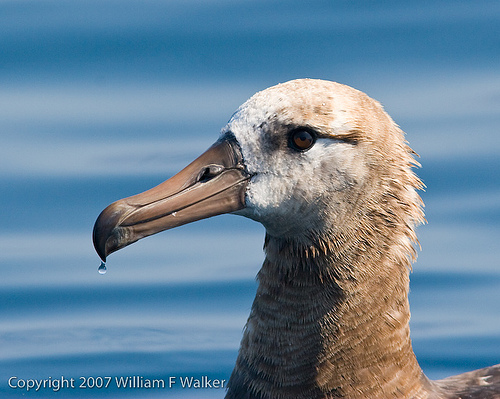

In [11]:
img

In [12]:
import PIL.ImageDraw

In [13]:
draw = PIL.ImageDraw.Draw(img)

In [14]:
draw.rectangle([left,top,right,bottom],outline="red", width=2)

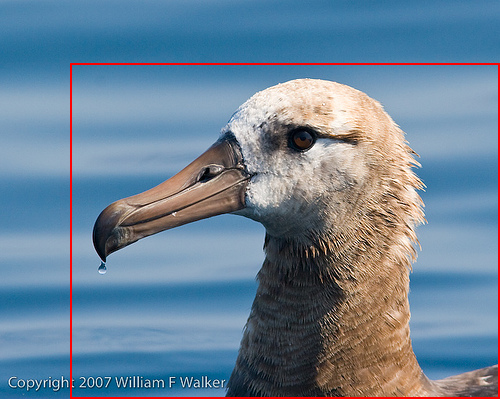

In [15]:
img

In [16]:
def get_bbox(filename):
    mat_file = scipy.io.loadmat(filename)
    bbox = mat_file['bbox'][0][0]
    left = bbox[0][0][0]
    top = bbox[1][0][0]
    right = bbox[2][0][0]
    bottom = bbox[3][0][0]
    return [left, top, right, bottom]

In [17]:
def draw_bbox(imagepath, bboxpath):
    bbox = get_bbox(bboxpath)
    img = PIL.Image.open(imagepath)
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(bbox,outline="red", width=2)
    return img

In [18]:
img = draw_bbox(
    "data/images/003.Sooty_Albatross/Sooty_Albatross_0001_389284737.jpg",
    "data/annotations/003.Sooty_Albatross/Sooty_Albatross_0001_389284737.mat"
    )

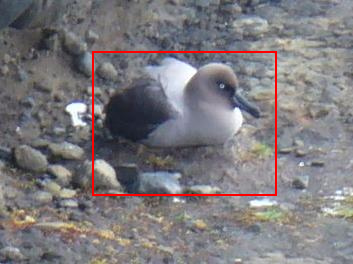

In [19]:
img

In [20]:
import os

In [21]:
def delete_file(base_path):
    path = os.listdir(base_path)
    for p in path:
        ppath = os.listdir(os.path.join(base_path,p))
        for pp in ppath:
            if pp.startswith("._"):
                os.remove(os.path.join(base_path,p,pp))

In [22]:
delete_file("data/images/")

In [23]:
# for _ , dir, filename in os.walk("data/images"):
#     print(dir)
#     for ffile in filename:
#         pass

In [24]:
def list_files(base_path):
    filepaths = []
    subdirs = os.listdir(base_path)
    for subdir in subdirs:
        subdir_path = os.path.join(base_path, subdir)
        files = os.listdir(subdir_path)
        for file_p in files:
            filepaths.append(os.path.join(base_path, subdir,file_p))
    return filepaths

In [25]:
images = list_files("data/images/")
bboxes = list_files("data/annotations/")

In [26]:
images[0]

'data/images/001.Black_footed_Albatross\\Black_footed_Albatross_0001_2950163169.jpg'

In [27]:
bboxes[0]

'data/annotations/001.Black_footed_Albatross\\Black_footed_Albatross_0001_2950163169.mat'

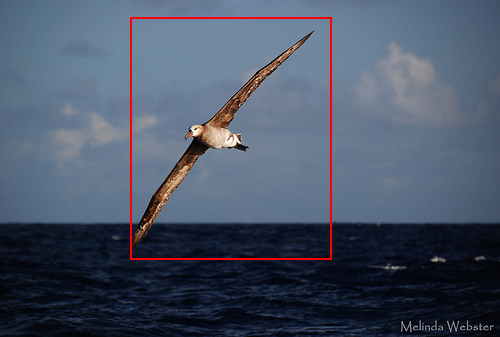

In [28]:
draw_bbox(images[3], bboxes[3])

In [29]:
# image_paths

### Preparing training data
Let's use generator to generate the training data since the data is big so keeping all the data in memory slows down the process

In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def prepare_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.float16)
    shape = img.numpy().shape
    img = tf.image.resize(img,[224,224])
    return img, shape   

In [32]:
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [33]:
def resize_bbox(bbox, shape):
    height, width , _ = shape
    left, top, right, bottom = bbox
    left = left * (224/width)
    top = top * (224/height)
    right = right * (224/width)
    bottom = bottom * (224/height)
    return np.array([left, top, right, bottom])

In [34]:
def prepare_data(images, annotations):
    for idx in range(len(images)):
        image = images[idx]
        annotation = annotations[idx]
        image, shape = prepare_image(image)
        bbox = get_bbox(annotation)
        bbox = resize_bbox(bbox, shape)
        yield image, bbox

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train_images, val_images, train_annos, val_annos = train_test_split(images, bboxes, test_size=0.15, random_state=42)

In [37]:
train_images, test_annos, train_annos, test_annos = train_test_split(train_images, train_annos, test_size=0.10, random_state=42)

In [38]:
len(test_annos)

513

In [39]:
train_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[train_images, train_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )   

In [40]:
val_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[val_images, val_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )  

In [41]:
test_dataset = tf.data.Dataset.from_generator(
                prepare_data,
                args=[test_annos, test_annos],
                output_types=(tf.float16, tf.float16),
                output_shapes=(
                    (224,224,3),
                    (4,)
                )
            )  

In [64]:
train_dataset = train_dataset.shuffle(100).repeat().batch(2)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(100).batch(1).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(100).batch(1).prefetch(tf.data.AUTOTUNE)

## Build Model
Let's build a model for object localization. We can make use of pretrained models for easiness.

In [77]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [80]:
mobile_net_model = MobileNetV2(include_top=False,
                  input_shape=(224,224,3))

In [81]:
mobile_net_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [82]:
model = tf.keras.models.Sequential()
model.add(vgg_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4))

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               32113152  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.MSE(),
    metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, epochs=5, steps_per_epoch=len(train_images)//20, validation_data=val_dataset)

In [66]:
def draw_bbox(imagepath, bbox):
    img = PIL.Image.open(imagepath)
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(bbox,outline="red", width=2)
    return img

In [67]:
def predict_and_draw(model,image_path):
    image, shape = prepare_image(image_path)
    image = image[np.newaxis,...]
    bbox = model.predict(image)
    img = draw_bbox(image_path, bbox)
    return img

In [71]:
def iou(original, predicted):
    x1, y1, x2, y2 = original
    x3, y3, x4, y4 = predicted
    x_inter_1 = max(x1, x3)
    y_inter_1 = max(y1, y3)
    x_inter_2 = min(x2, x4)
    y_inter_2 = min(y2, y4)

    inter_width = max(x_inter_2 - x_inter_1, 0)
    inter_height = max(y_inter_2 - y_inter_1, 0)
    inter_area = inter_height * inter_width

    box1_width = abs(x2-x1)
    box1_height = abs(y2-y1)
    box2_width = abs(x4-x3)
    box2_height = abs(y4-y3)
    box1_area = box1_height * box1_width
    box2_area = box2_height * box2_width

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

In [74]:
def draw_original_and_predicted_box(image_path, box1, box2):
    img = PIL.Image.open(imagepath)
    draw = PIL.ImageDraw.Draw(img)
    draw.rectangle(box1,outline="red", width=2)
    draw.rectangle(box2,outline="blue", width=2)
    return img